In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

import torch 
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm import utils
from timm.loss import JsdCrossEntropy, SoftTargetCrossEntropy, BinaryCrossEntropy, LabelSmoothingCrossEntropy
from timm import scheduler
from torch.optim import Adam
import glob
from tqdm.notebook import tqdm
import argparse
import logging
import os
import time
from collections import OrderedDict
from contextlib import suppress
from datetime import datetime
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.utils
import yaml
from torch.nn.parallel import DistributedDataParallel as NativeDDP
from PIL import Image
import torchvision
from timm.data import resolve_data_config
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('The model will be running on', device, 'device')

The model will be running on cuda:0 device


In [3]:
class mode_gem(nn.Module):    
    def __init__(self, features, pool, in_features):
        super(mode_gem, self).__init__()
        self.features = nn.Sequential(*features)
        self.fc = nn.Linear(in_features, 3)
        self.pool = pool
    
    def forward(self, x):
        o = self.features(x)
        o = self.pool(o).squeeze(-1).squeeze(-1)
        o = self.fc(o)
        return o
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
def create_model_gem(config):
    models_b4 = timm.create_model(
        config.model,
        pretrained=config.pretrained,
        in_chans=config.in_chans,
        num_classes=config.num_classes,
        drop_rate=config.drop,
        drop_path_rate=config.drop_path,
        global_pool=config.gp
    )
    in_features  = None
    if "convnet" in config.model: 
        in_features  = models_b4.head.in_features    # cho convnet 
    else :
        in_features  = models_b4.classifier.in_features # cho eff
    features = list(models_b4.children())[:-2]
    pool = GeM()
    model_pool = mode_gem(features, pool, in_features)
    return model_pool

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, data_path_file, train=True):
        super(Dataset, self).__init__()
        self.data = pd.read_csv(data_path_file,index_col=0)
        self.global_path = "kaggle/input/meta-data/Data_image/"

        if train:
            # Define the training data augmentation pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(384,384)),
                transforms.RandomResizedCrop(size=(384,384), scale=(0.8, 1), ratio=(0.45, 0.55)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),

                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])
        else:
            # Define the validation and testing pipeline
            self.transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(size=(384,384)),
#                 transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        #malignant is 2
        #benign is 1
        #normal is 0
        label = row['status']
        if row['Type'] == 'rsna':
            img_path = os.path.join("kaggle/input/rsna-1024x512/",row["Path"])
        else: 
            img_path = os.path.join(self.global_path,row["Path"])
        if row['Type'] == 'ddsm':
            img_path = os.path.join("kaggle/input/",row["Path"])
        labels = torch.tensor(label)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, labels

In [5]:
class focal_loss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2, reduction: str = "none"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
        Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

        Args:
            inputs: A float tensor of arbitrary shape.
                    The predictions for each example.
            targets: A float tensor with the same shape as inputs. Stores the binary
                    classification label for each element in inputs
                    (0 for the negative class and 1 for the positive class).
            alpha: (optional) Weighting factor in range (0,1) to balance
                    positive vs negative examples or -1 for ignore. Default = 0.25
            gamma: Exponent of the modulating factor (1 - p_t) to
                   balance easy vs hard examples.
            reduction: 'none' | 'mean' | 'sum'
                     'none': No reduction will be applied to the output.
                     'mean': The output will be averaged.
                     'sum': The output will be summed.
        Returns:
            Loss tensor with the reduction option applied.
        """

#         if not torch.jit.is_scripting() and not torch.jit.is_tracing():
#             _log_api_usage_once(sigmoid_focal_loss)
        p = torch.sigmoid(inputs)
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [6]:
path_test_DDSM = f'kaggle/input/train-rsna-cmmd-ddsm/Train1/test.csv'

In [7]:
class Parameter_model:
    def __init__(self):
        self.channels_last = None
        self.pretrained = True
        self.in_chans = 3
        self.num_classes = 3
        self.drop = 0.5
        self.drop_path = 0.2
        self.gp = 'avg'
        self.num_epochs = 100

        self.lr = 3e-5
        self.grad_checkpointing = True
        self.channels_last = True
        self.model = "efficientnet_b0"
        self.smoothing = 0.1
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True

In [8]:
def check_exits(path):
    data = pd.read_csv(path)
    global_path =  "kaggle/input/meta-data/Data_image/"
    for idx in tqdm(data.index):
        row = data.iloc[idx]
        #malignant is 2
        #benign is 1
        #normal is 0
        label = row['status']
        if row['Type'] == 'rsna':
            img_path = os.path.join("kaggle/input/rsna-1024x512/",row["Path"])
        else: 
            img_path = os.path.join(global_path,row["Path"])
        if row['Type'] == 'ddsm':
            img_path = os.path.join("kaggle/input/",row["Path"])
        if os.path.exists(img_path) == False:
            print(img_path)

In [9]:
os.path.exists('kaggle/input/rsna-1024x512/MLO_2002094699.png')

True

In [10]:
check_exits(path_test_DDSM)


  0%|          | 0/2992 [00:00<?, ?it/s]

In [11]:
batch_size = 32
test_dataset_DDSM = BreastCancerDataset(path_test_DDSM,train=False)
test_loader_DDSM = DataLoader(test_dataset_DDSM,batch_size=batch_size,shuffle=True)

In [12]:
class ensembleModel(nn.Module):
    def __init__(self, config, pth_paths) -> None:
        super(ensembleModel, self).__init__()
        list_model = []
        config.pretrained = False
        for i, path in enumerate(pth_paths):
            print(f"Loading model {path}")
            config.model = 'efficientnetv2_s'
            if 'vit' in path :
                config.model = 'vit_small_patch16_384'
            if 'b0' in path :
                config.model = 'efficientnet_b0'
                config.gp = 'avg'
                
            checkpoint = torch.load(path)
            best_model_state_dict = checkpoint['model_state_dict']
            if 'vit' in path:
                
                model = timm.create_model(
                    config.model,
                    pretrained=config.pretrained,
                    in_chans=config.in_chans,
                    num_classes=config.num_classes,
                    drop_rate=config.drop,
                    drop_path_rate=config.drop_path,
                    global_pool=config.gp)
            else:
                # checkpoint = torch.load(path)
                # best_model_state_dict = checkpoint['model_state_dict']
                model = create_model_gem(config)
            model.load_state_dict(best_model_state_dict)
            model = model.eval()
            # Get information of model use resolve_data_config function
            data_config = resolve_data_config({}, model=model)
            print(f"Data Config {data_config}")
            mean = np.array(data_config['mean'])*255
            std = np.array(data_config['std'])*255
            print(f'mean={mean}, std={std}')
            list_model.append(model)
        self.list_models = nn.ModuleList(list_model)
        
        self.register_buffer('mean', torch.FloatTensor(mean).reshape(1, 3, 1, 1))
        self.register_buffer('std', torch.FloatTensor(std).reshape(1, 3, 1, 1))
    def forward(self, x):
        # x = (x - self.mean)/self.std 
        
        probs = []
        s = None
        
        for model in self.list_models:
            logit  = model(x)
            prob = F.softmax(logit, dim=1)
            # print(prob)
            if s == None:
                s = prob
            else:
                s += prob
            
        s/=len(self.list_models)
        # print(s)
        return s

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    y_true = []
    y_pred = []
    for (inputs, labels) in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        model.to(device)
        outputs = model(inputs)
        predicted = torch.max(outputs,dim=1)[1]

        y_true += labels.tolist()
        y_pred += predicted.tolist()
        
# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=3)
# auc_score = auc(fpr, tpr)

num_labels  =2
y_true_one_hot = np.eye(num_labels)[y_true]
y_pred_one_hot = np.eye(num_labels)[y_pred]
auc_scores = []
for label in range(num_labels):
    auc = roc_auc_score(y_true_one_hot[:, label], y_pred_one_hot[:, label])
    auc_scores.append(auc)

# print("AUC scores for each label:", auc_scores)



# print(f"Result {name_model}")
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 score: {f1:.2f}')
print(f'AUC normal: {auc_scores[0]:.2f}')
print(f'AUC benign: {auc_scores[1]:.2f}')
# print(f'AUC malignant: {auc_scores[2]:.2f}')

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['benign','malignant'])
disp.plot()
plt.savefig('confusion_matrix_DDSM.png')
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score

def runing_model(ensamble_model, name_model):
    print(f'Starting model {name_model}')
    with torch.no_grad():
        y_true = []
        y_pred = []
        for (inputs, labels) in tqdm(test_loader_DDSM):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            ensamble_model.to(device)
            outputs = ensamble_model(inputs)
            predicted = torch.max(outputs,dim=1)[1]

            y_true += labels.tolist()
            y_pred += predicted.tolist()
            # print('Done')
            
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=3)
    # auc_score = auc(fpr, tpr)
    
    num_labels  =3
    y_true_one_hot = np.eye(num_labels)[y_true]
    y_pred_one_hot = np.eye(num_labels)[y_pred]
    auc_scores = []
    for label in range(num_labels):
        auc = roc_auc_score(y_true_one_hot[:, label], y_pred_one_hot[:, label])
        auc_scores.append(auc)
    
    # print("AUC scores for each label:", auc_scores)
        
    
    
    print(f"Result {name_model}")
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 score: {f1:.2f}')
    print(f'AUC normal: {auc_scores[0]:.2f}')
    print(f'AUC benign: {auc_scores[1]:.2f}')
    print(f'AUC malignant: {auc_scores[2]:.2f}')
    
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['normal','benign','malignant'])
    disp.plot()
    plt.savefig(f'output/{name_model}.png')
    return {
        'Result': name_model,
        'Accuracy': f'{accuracy:.2f}',
        'Precision': f'{precision:.2f}',
        'Recall': f'{recall:.2f}',
        'F1 score': f'{f1:.2f}',
        'AUC normal': f'{auc_scores[0]:.2f}',
        'AUC benign':f'{auc_scores[1]:.2f}',
        'AUC malignant':f'{auc_scores[2]:.2f}',
    }

In [48]:
def validate_ensamble_model(path):
    pth_paths = glob.glob(path)
    print(pth_paths)
    config = Parameter_model()
    len_bit = len(pth_paths)
    k = 0 # number has value <= 2^len(x)
    '''
    Accuracy: 0.71
    Precision: 0.72
    Recall: 0.71
    F1 score: 0.71
    AUC score : 0.71
    '''
    # df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC normal', 'AUC benign', 'AUC malignant'])
    df = []
    
    while k < (1 << len_bit):
        i = 0
        name_model = ''
        choice_model = []
        id = []
        s = ''
        while i < len_bit:
            if k & (1 << i):
                choice_model.append(pth_paths[i])    
                name_model += os.path.basename(pth_paths[i]).replace('.pth', '') + '_'
                id.append(i)
                s = '1' + s
            else:
                s = '0' + s
            i +=1
        if len(choice_model) == 0: 
            k+=1
            continue
        
        # print("++++++++++++++++++++++")
        print(s)
        # print(id)
        # print(len(choice_model))
        # print(name_model)
        # print("++++++++++++++++++++++")
        # Runing model ensamble learning
        ensamble_model = ensembleModel(config=config, pth_paths=choice_model)
        result = runing_model(ensamble_model, name_model)
        df.append(result)
        # df.to_csv('output/result_ensamble.csv')
        k+=1
    data = pd.DataFrame(df)
    data.to_csv('output/result_ensamble.csv')

['Weight_model\\efficienetb0_14.pth', 'Weight_model\\efficienetv2s_25.pth', 'Weight_model\\efficientnet_b0_39_Focalloss.pth', 'Weight_model\\vit_small_patch16_384_8.pth']
0001
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficienetb0_14_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_
Accuracy: 0.71
Precision: 0.74
Recall: 0.71
F1 score: 0.72
AUC normal: 0.86
AUC benign: 0.74
AUC malignant: 0.73
0010
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficienetv2s_25_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetv2s_25_
Accuracy: 0.61
Precision: 0.64
Recall: 0.61
F1 score: 0.61
AUC normal: 0.78
AUC benign: 0.64
AUC malignant: 0.69
0011
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficienetb0_14_efficienetv2s_25_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficienetv2s_25_
Accuracy: 0.70
Precision: 0.72
Recall: 0.70
F1 score: 0.70
AUC normal: 0.85
AUC benign: 0.73
AUC malignant: 0.73
0100
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficientnet_b0_39_Focalloss_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficientnet_b0_39_Focalloss_
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 score: 0.70
AUC normal: 0.87
AUC benign: 0.73
AUC malignant: 0.70
0101
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficienetb0_14_efficientnet_b0_39_Focalloss_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficientnet_b0_39_Focalloss_
Accuracy: 0.71
Precision: 0.73
Recall: 0.71
F1 score: 0.72
AUC normal: 0.87
AUC benign: 0.74
AUC malignant: 0.72
0110
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Starting model efficienetv2s_25_efficientnet_b0_39_Focalloss_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetv2s_25_efficientnet_b0_39_Focalloss_
Accuracy: 0.70
Precision: 0.71
Recall: 0.70
F1 score: 0.70
AUC normal: 0.86
AUC benign: 0.72
AUC malignant: 0.71
0111
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=

  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficienetv2s_25_efficientnet_b0_39_Focalloss_
Accuracy: 0.71
Precision: 0.72
Recall: 0.71
F1 score: 0.72
AUC normal: 0.87
AUC benign: 0.74
AUC malignant: 0.72
1000
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5 127.5 127.5]
Starting model vit_small_patch16_384_8_


  0%|          | 0/94 [00:00<?, ?it/s]

Result vit_small_patch16_384_8_
Accuracy: 0.67
Precision: 0.69
Recall: 0.67
F1 score: 0.67
AUC normal: 0.84
AUC benign: 0.69
AUC malignant: 0.71
1001
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5 127.5 127.5]
Starting model efficienetb0_14_vit_small_patch16_384_8_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_vit_small_patch16_384_8_
Accuracy: 0.72
Precision: 0.74
Recall: 0.72
F1 score: 0.72
AUC normal: 0.88
AUC benign: 0.74
AUC malignant: 0.73
1010
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5 127.5 127.5]
Starting model efficienetv2s_25_vit_small_patch16_384_8_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetv2s_25_vit_small_patch16_384_8_
Accuracy: 0.66
Precision: 0.67
Recall: 0.66
F1 score: 0.66
AUC normal: 0.83
AUC benign: 0.68
AUC malignant: 0.71
1011
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5 127.5 127.5]
Starting m

  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficienetv2s_25_vit_small_patch16_384_8_
Accuracy: 0.71
Precision: 0.73
Recall: 0.71
F1 score: 0.72
AUC normal: 0.87
AUC benign: 0.74
AUC malignant: 0.73
1100
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5 127.5 127.5]
Starting model efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_


  0%|          | 0/94 [00:00<?, ?it/s]

Result efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1 score: 0.72
AUC normal: 0.88
AUC benign: 0.73
AUC malignant: 0.72
1101
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 127.5], std=[127.5

  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_
Accuracy: 0.72
Precision: 0.74
Recall: 0.72
F1 score: 0.73
AUC normal: 0.88
AUC benign: 0.74
AUC malignant: 0.73
1110
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\vit_small_patch16_384_8.pth
Data Config {'input_size': (3, 384, 384), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 1.0, 'crop_mode': 'center'}
mean=[127.5 127.5 1

  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetv2s_25_efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_
Accuracy: 0.71
Precision: 0.72
Recall: 0.71
F1 score: 0.71
AUC normal: 0.87
AUC benign: 0.73
AUC malignant: 0.72
1111
Loading model Weight_model\efficienetb0_14.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficienetv2s_25.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.675 116.28  103.53 ], std=[58.395 57.12  57.375]
Loading model Weight_model\efficientnet_b0_39_Focalloss.pth
Data Config {'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.875, 'crop_mode': 'center'}
mean=[123.67

  0%|          | 0/94 [00:00<?, ?it/s]

Result efficienetb0_14_efficienetv2s_25_efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1 score: 0.72
AUC normal: 0.88
AUC benign: 0.74
AUC malignant: 0.72


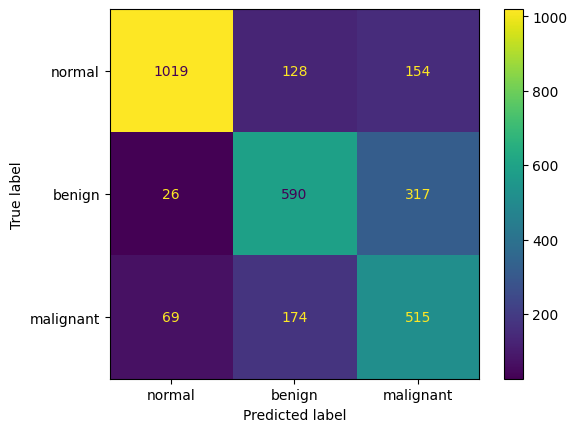

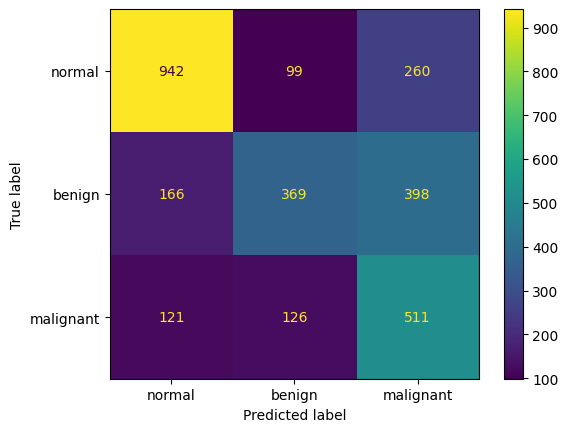

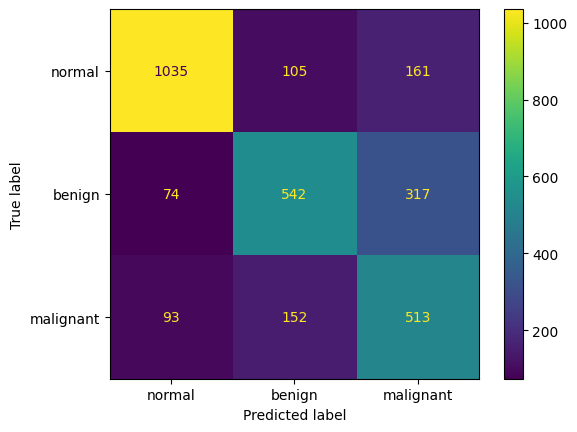

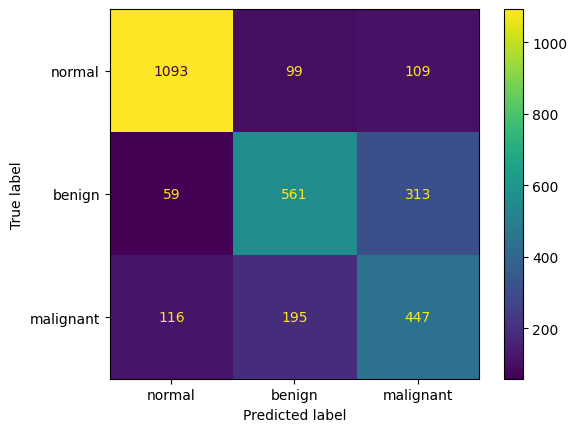

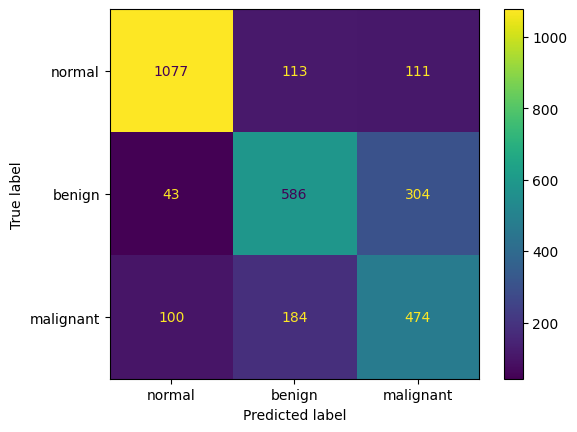

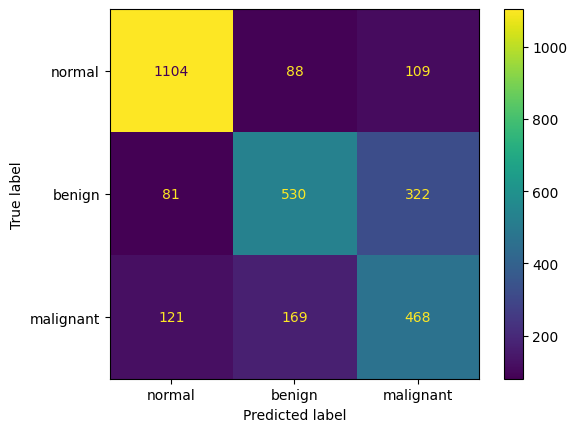

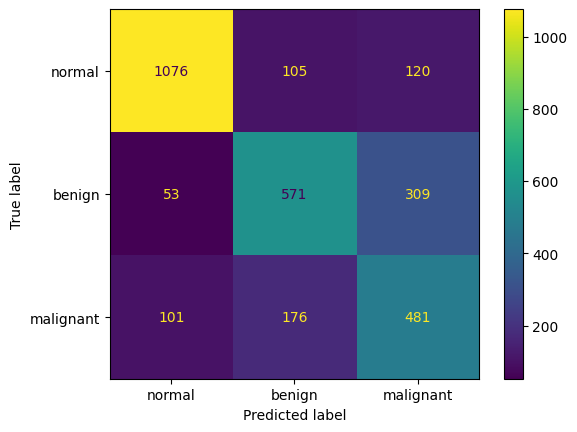

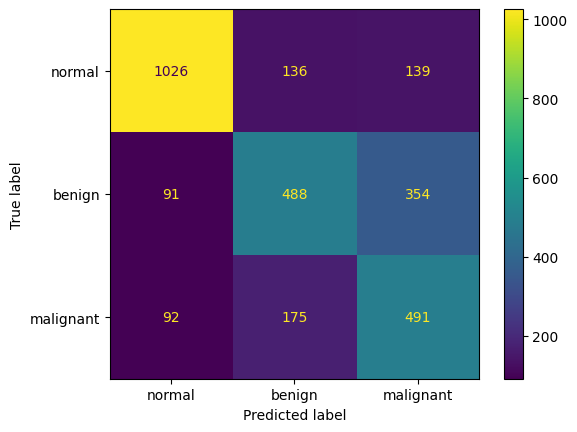

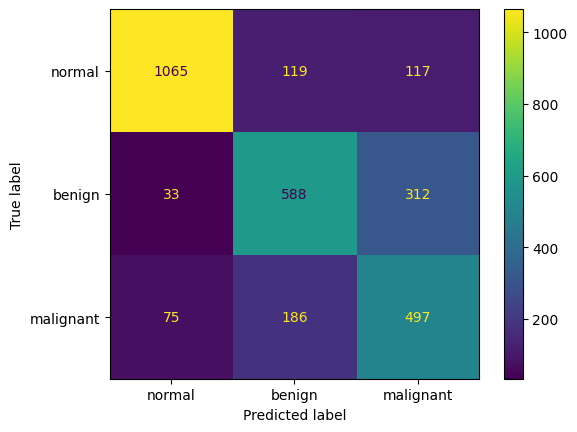

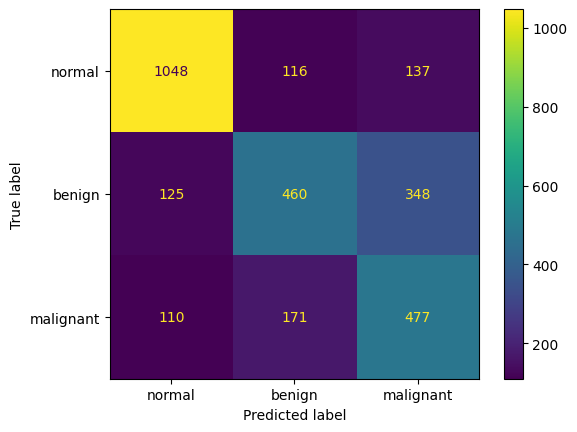

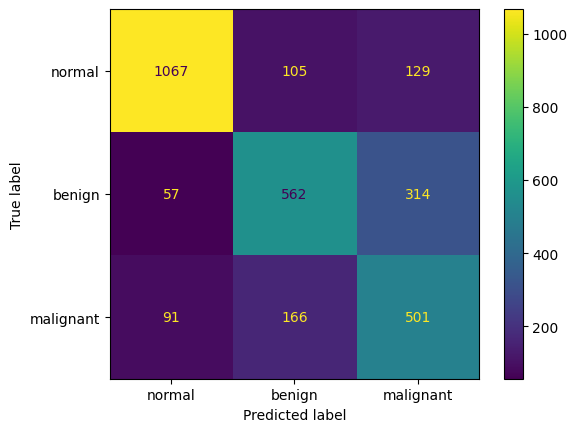

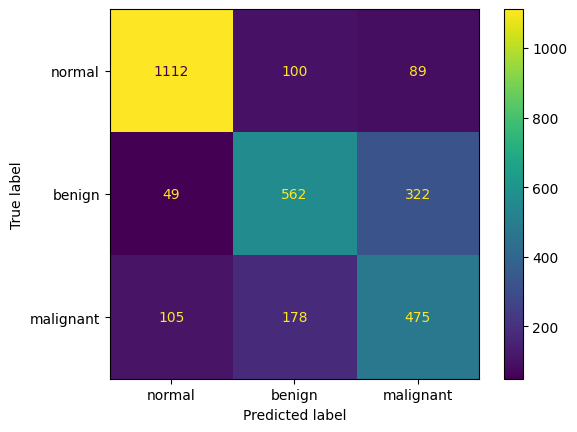

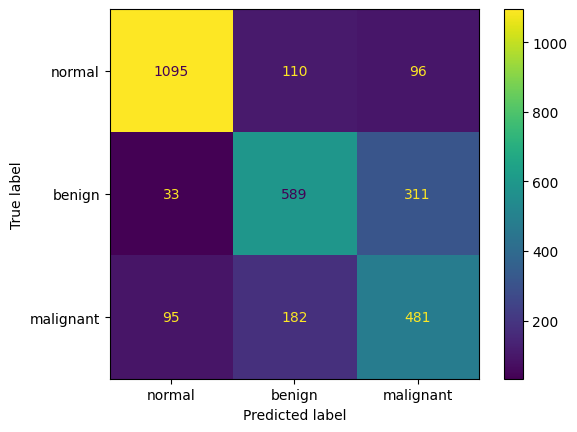

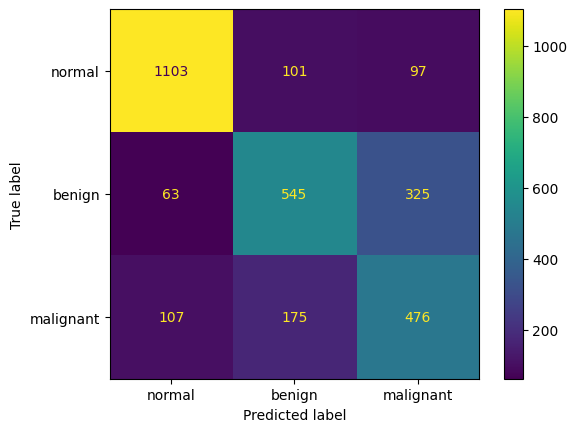

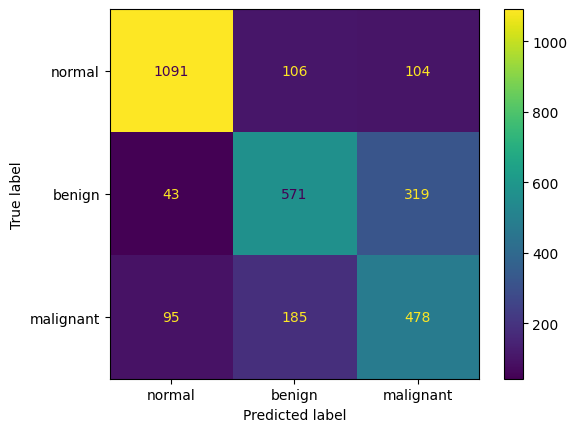

In [49]:
# pth_paths = glob.glob('Weight_model/*')
# pth_paths = [r'E:/FDSE/Weight_model/efficientnet_b0_39_Focalloss.pth']

validate_ensamble_model('Weight_model/*')

In [50]:
data = pd.read_csv('output/result_ensamble.csv')

In [51]:
data

,Unnamed: 0,Result,Accuracy,Precision,Recall,F1 score,AUC normal,AUC benign,AUC malignant
0,0,efficienetb0_14_,0.71,0.74,0.71,0.72,0.86,0.74,0.73
1,1,efficienetv2s_25_,0.61,0.64,0.61,0.61,0.78,0.64,0.69
2,2,efficienetb0_14_efficienetv2s_25_,0.70,0.72,0.70,0.70,0.85,0.73,0.73
3,3,efficientnet_b0_39_Focalloss_,0.70,0.71,0.70,0.70,0.87,0.73,0.70
4,4,efficienetb0_14_efficientnet_b0_39_Focalloss_,0.71,0.73,0.71,0.72,0.87,0.74,0.72
5,5,efficienetv2s_25_efficientnet_b0_39_Focalloss_,0.70,0.71,0.70,0.70,0.86,0.72,0.71
6,6,efficienetb0_14_efficienetv2s_25_efficientnet_...,0.71,0.72,0.71,0.72,0.87,0.74,0.72
7,7,vit_small_patch16_384_8_,0.67,0.69,0.67,0.67,0.84,0.69,0.71
8,8,efficienetb0_14_vit_small_patch16_384_8_,0.72,0.74,0.72,0.72,0.88,0.74,0.73
9,9,efficienetv2s_25_vit_small_patch16_384_8_,0.66,0.67,0.66,0.66,0.83,0.68,0.71


In [52]:
data.sort_values(by='F1 score',     ascending=False)

,Unnamed: 0,Result,Accuracy,Precision,Recall,F1 score,AUC normal,AUC benign,AUC malignant
12,12,efficienetb0_14_efficientnet_b0_39_Focalloss_v...,0.72,0.74,0.72,0.73,0.88,0.74,0.73
0,0,efficienetb0_14_,0.71,0.74,0.71,0.72,0.86,0.74,0.73
4,4,efficienetb0_14_efficientnet_b0_39_Focalloss_,0.71,0.73,0.71,0.72,0.87,0.74,0.72
6,6,efficienetb0_14_efficienetv2s_25_efficientnet_...,0.71,0.72,0.71,0.72,0.87,0.74,0.72
8,8,efficienetb0_14_vit_small_patch16_384_8_,0.72,0.74,0.72,0.72,0.88,0.74,0.73
10,10,efficienetb0_14_efficienetv2s_25_vit_small_pat...,0.71,0.73,0.71,0.72,0.87,0.74,0.73
11,11,efficientnet_b0_39_Focalloss_vit_small_patch16...,0.72,0.73,0.72,0.72,0.88,0.73,0.72
14,14,efficienetb0_14_efficienetv2s_25_efficientnet_...,0.72,0.73,0.72,0.72,0.88,0.74,0.72
13,13,efficienetv2s_25_efficientnet_b0_39_Focalloss_...,0.71,0.72,0.71,0.71,0.87,0.73,0.72
2,2,efficienetb0_14_efficienetv2s_25_,0.70,0.72,0.70,0.70,0.85,0.73,0.73


In [54]:
data.iloc[12].Result           

'efficienetb0_14_efficientnet_b0_39_Focalloss_vit_small_patch16_384_8_'

from sklearn.metrics import roc_auc_score

y_true = np.array([[1, 0, 0],  # Nhãn thực tế cho mẫu 1
                   [0, 1, 0],  # Nhãn thực tế cho mẫu 2
                   [0, 0, 1],  # Nhãn thực tế cho mẫu 3
                   [1, 0, 0],  # Nhãn thực tế cho mẫu 4
                   [1, 0, 0],  # Nhãn thực tế cho mẫu 5
                   [0, 1, 0]]) # Nhãn thực tế cho mẫu 6

y_pred = np.array([[0.8, 0.1, 0.1],  # Dự đoán cho mẫu 1
                   [0.2, 0.7, 0.1],  # Dự đoán cho mẫu 2
                   [0.1, 0.3, 0.6],  # Dự đoán cho mẫu 3
                   [0.9, 0.05, 0.05], # Dự đoán cho mẫu 4
                   [0.7, 0.2, 0.1],  # Dự đoán cho mẫu 5
                   [0.1, 0.6, 0.3]]) # Dự đoán cho mẫu 6

# Tính AUC cho mỗi lớp
num_labels = y_true.shape[1]
auc_scores = []

for label in range(num_labels):
    auc = roc_auc_score(y_true[:, label], y_pred[:, label])
    print(y_true[:, label], y_pred[:, label])
    auc_scores.append(auc)

print("AUC scores for each label:", auc_scores)

In [ ]:
import os
os.makerdirs()

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [55]:
print(y_true_one_hot[:, 0])

[1. 0. 0. 1. 1. 0.]


In [56]:
auc = roc_auc_score(y_true_one_hot[:, 0], y_pred_one_hot[:, 0])

In [57]:
auc

0.8333333333333333